# Non-negative Matrix Factorization (NMF)
**NOTE:** First you should check "Quora-TopicModeling-scikit-learn-LDA" kernel, before studying this kernel.
* Family of linear algebra algorithms for identifying the latent structure in data represented as a non-negative matrix.
* NMF can be applied for topic modeling, where the input is term-document matrix, typically TF-IDF normalized.
* Input: Term-Document matrix, number of topics.
* Output: Two non-negative matrices of the original n words by k topics and those same k topics by the m original documents.
* Basically, we are going to use linear algebra for topic modeling.

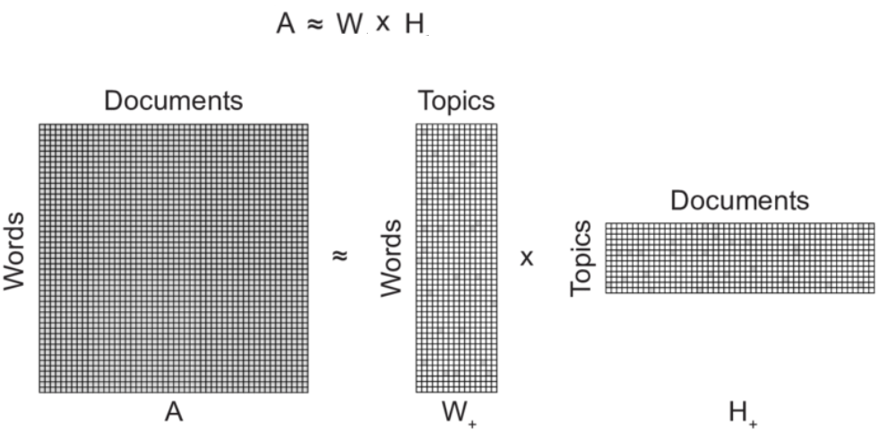



As illustrated above, we take the term-document matrix, decompose to two matrices, first one has every topic and what terms in it, and 2nd one has every document and what topics in it.
# Let’s use our football and politics example again:

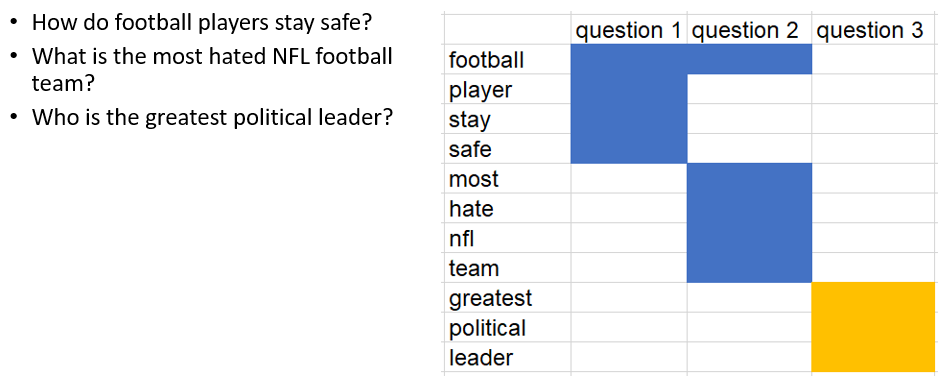


On the left we have 3 questions, on the right we have term-document matrix for these 3 questions. We choose k=2 topics.

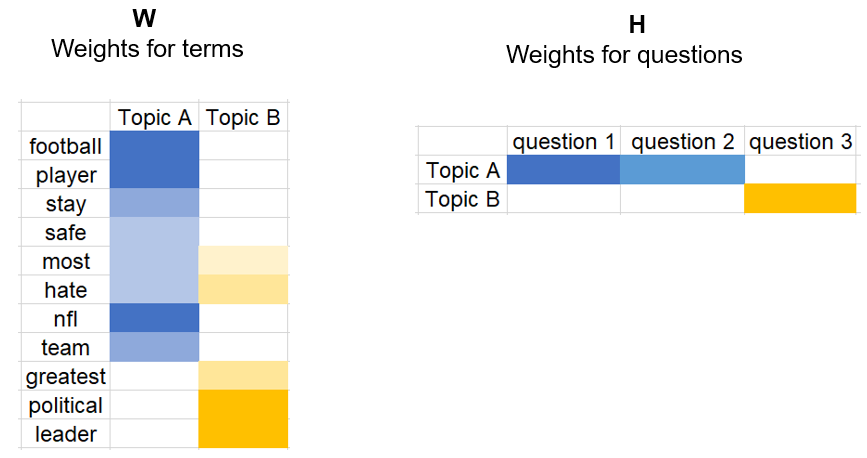

After decomposition, we got two non-negative matrices of the original n words by k topics and those same k topics by the m original documents.
The text pre-processing part were similar with the LDA model, and I kept nouns only for NMF model, just to see whether any difference.
We can see that how each keywords were allocated in each topic and how topics organization can be quite different compare with LDA model.


In [1]:
import pandas as pd
import numpy as np

import re, nltk, spacy, gensim, string

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfTransformer;
from sklearn.decomposition import NMF;
from sklearn.preprocessing import normalize
from pprint import pprint

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline



import warnings
warnings.simplefilter(action='ignore', category=Warning)

/opt/conda/lib/python3.7/site-packages/past/types/oldstr.py:36: DeprecationWarning: invalid escape sequence \d
  """


In [2]:
df = pd.read_csv('../input/quoradatasets/df_clean.csv')

In [3]:
df.head()

,question_text,question_lemmatize,question_lemmatize_clean
0,why is saturn v considered an overestimated ro...,why be saturn v consider an overestimated rock...,why be saturn v consider an overestimated rock...
1,why is cheap vodka so good,why be cheap vodka so good,why be cheap vodka so good
2,what does drunk and disorganized mean,what do drunk and disorganized mean,what do drunk and disorganized mean
3,how can i prepare for isro,how can I prepare for isro,how can I prepare for isro
4,what is the probation period after ssc cgl,what be the probation period after ssc cgl,what be the probation period after ssc cgl


In [4]:
df['question_lemmatize_clean'] = df['question_lemmatize'].str.replace('-PRON-', '')

In [5]:
df.head(5)

,question_text,question_lemmatize,question_lemmatize_clean
0,why is saturn v considered an overestimated ro...,why be saturn v consider an overestimated rock...,why be saturn v consider an overestimated rock...
1,why is cheap vodka so good,why be cheap vodka so good,why be cheap vodka so good
2,what does drunk and disorganized mean,what do drunk and disorganized mean,what do drunk and disorganized mean
3,how can i prepare for isro,how can I prepare for isro,how can I prepare for isro
4,what is the probation period after ssc cgl,what be the probation period after ssc cgl,what be the probation period after ssc cgl


In [6]:
import nltk
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [7]:
from nltk import word_tokenize, pos_tag

def nouns(text):
    '''Given a string of text, tokenize the text and pull out only the nouns.'''
    is_noun = lambda pos: pos[:2] == 'NN'
    tokenized = word_tokenize(text)
    all_nouns = [word for (word, pos) in pos_tag(tokenized) if is_noun(pos)]
    return ' '.join(all_nouns)

In [8]:
df_nouns = pd.DataFrame(df.question_lemmatize_clean.apply(nouns))
df_nouns

,question_lemmatize_clean
0,rocket mission
1,vodka
2,drunk mean
3,isro
4,probation period ssc cgl
...,...
9833,mueller
9834,
9835,paul jail time execution record body
9836,state government property title registration


In [9]:
df_nouns.to_csv('df_nouns.csv', index=False)

In [10]:
df_nouns = pd.read_csv('df_nouns.csv')

In [11]:
df_nouns.head()

,question_lemmatize_clean
0,rocket mission
1,vodka
2,drunk mean
3,isro
4,probation period ssc cgl


In [12]:
n_features = 4000
n_components = 20
n_top_words = 20

In [13]:
# ignore terms that have a document frequency strictly higher than 95%,
# ignore terms that have a document frequency strictly lower than 2
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=n_features,
                                   stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(df_nouns['question_lemmatize_clean'].values.astype(str))

In [14]:
# alpha=0 means no regularization, l1_ratio=.5, the penalty is a combination of L1 and L2
nmf = NMF(n_components=n_components, random_state=1, alpha=.1, l1_ratio=.5).fit(tfidf)

In [15]:
nmf_output = nmf.fit_transform(tfidf)

In [16]:
def show_topics(vectorizer=tfidf_vectorizer, lda_model=nmf, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=tfidf_vectorizer, lda_model=nmf, n_words=20)

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15,Word 16,Word 17,Word 18,Word 19
Topic 0,nan,ab,physiotherapy,piano,pic,pichai,pick,picture,pie,piece,pill,pilot,pimple,pin,pink,pipe,pipeline,pisa,pistol,pitch
Topic 1,people,age,government,face,family,country,group,pain,suicide,role,order,letter,music,look,car,hair,relationship,culture,story,status
Topic 2,way,weight,business,fast,quality,online,home,anxiety,skill,electricity,datum,point,word,function,example,blog,air,health,intelligence,travel
Topic 3,life,change,experience,quora,dream,moment,need,quality,parent,family,goal,form,span,try,phd,wise,sex,lesson,design,practice
Topic 4,thing,amazon,quora,horror,business,weekend,interview,future,storage,spouse,god,average,purpose,today,kid,room,physics,china,war,vehicle
Topic 5,india,course,future,institute,college,cost,trend,economy,state,ship,wealth,rape,fresher,news,girl,vegetarian,china,tax,pakistan,site
Topic 6,time,sex,period,speed,space,mass,crush,change,husband,machine,fund,love,girl,quora,wife,developer,water,china,term,pay
Topic 7,use,machine,industry,type,chemistry,weapon,language,material,phone,disadvantage,advantage,device,power,rice,water,speaker,engine,gate,case,study
Topic 8,year,experience,student,engineering,cat,program,case,change,child,daughter,career,tall,salary,partner,relationship,female,university,question,developer,pass
Topic 9,job,interview,government,engineering,pay,canada,field,science,opportunity,student,hop,software,experience,uk,grade,apply,order,language,nigeria,computer


In [17]:
Topics_theme = ['Word start from ph', 'People/Friend/Relationship', 'Life/Experience/Love/Purpose', 'Money/Internet/Business',
                'Weekend/Parent/Child', 'Leisure time', 'Language/technique/software', 'Relationship/Girl/Boy',
                'Business relate to India, China or Pakistan', 'Friend/Love/Relationship', 'Difference and similarity/Language/Engineering',
                'Culture, travel and visa requirements in several countries', 'Tips on working as software engineering', 'Book/Movie/Class/History/Physics/Chemistry/Science',
                'Software engineer job opportunitis in Canada', 'Love/Life/Relationship', 'World/War/Language/History', 'Day/Hour/Week/Month/Sex/Place', 'School/Student/College/University',
                'Question/Answer/Quora/Interview']
df_topic_keywords['topic_theme'] = Topics_theme

In [18]:
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,...,Word 11,Word 12,Word 13,Word 14,Word 15,Word 16,Word 17,Word 18,Word 19,topic_theme
Topic 0,nan,ab,physiotherapy,piano,pic,pichai,pick,picture,pie,piece,...,pilot,pimple,pin,pink,pipe,pipeline,pisa,pistol,pitch,Word start from ph
Topic 1,people,age,government,face,family,country,group,pain,suicide,role,...,letter,music,look,car,hair,relationship,culture,story,status,People/Friend/Relationship
Topic 2,way,weight,business,fast,quality,online,home,anxiety,skill,electricity,...,point,word,function,example,blog,air,health,intelligence,travel,Life/Experience/Love/Purpose
Topic 3,life,change,experience,quora,dream,moment,need,quality,parent,family,...,form,span,try,phd,wise,sex,lesson,design,practice,Money/Internet/Business
Topic 4,thing,amazon,quora,horror,business,weekend,interview,future,storage,spouse,...,average,purpose,today,kid,room,physics,china,war,vehicle,Weekend/Parent/Child
Topic 5,india,course,future,institute,college,cost,trend,economy,state,ship,...,rape,fresher,news,girl,vegetarian,china,tax,pakistan,site,Leisure time
Topic 6,time,sex,period,speed,space,mass,crush,change,husband,machine,...,love,girl,quora,wife,developer,water,china,term,pay,Language/technique/software
Topic 7,use,machine,industry,type,chemistry,weapon,language,material,phone,disadvantage,...,device,power,rice,water,speaker,engine,gate,case,study,Relationship/Girl/Boy
Topic 8,year,experience,student,engineering,cat,program,case,change,child,daughter,...,tall,salary,partner,relationship,female,university,question,developer,pass,"Business relate to India, China or Pakistan"
Topic 9,job,interview,government,engineering,pay,canada,field,science,opportunity,student,...,software,experience,uk,grade,apply,order,language,nigeria,computer,Friend/Love/Relationship


In [19]:
df_topic_keywords.set_index('topic_theme', inplace=True)

In [20]:
df_topic_keywords.T

topic_theme,Word start from ph,People/Friend/Relationship,Life/Experience/Love/Purpose,Money/Internet/Business,Weekend/Parent/Child,Leisure time,Language/technique/software,Relationship/Girl/Boy,"Business relate to India, China or Pakistan",Friend/Love/Relationship,Difference and similarity/Language/Engineering,"Culture, travel and visa requirements in several countries",Tips on working as software engineering,Book/Movie/Class/History/Physics/Chemistry/Science,Software engineer job opportunitis in Canada,Love/Life/Relationship,World/War/Language/History,Day/Hour/Week/Month/Sex/Place,School/Student/College/University,Question/Answer/Quora/Interview
Word 0,nan,people,way,life,thing,india,time,use,year,job,book,person,difference,woman,friend,day,world,school,work,money
Word 1,ab,age,weight,change,amazon,course,sex,machine,experience,interview,history,history,carbon,man,family,period,country,student,tip,online
Word 2,physiotherapy,government,business,experience,quora,future,period,industry,student,government,movie,business,rice,guy,love,age,war,college,home,value
Word 3,piano,face,fast,quora,horror,institute,speed,type,engineering,engineering,physics,word,experience,sex,depression,week,business,class,canada,account
Word 4,pic,family,quality,dream,business,college,space,chemistry,cat,pay,theme,sex,state,marriage,parent,letter,power,grade,computer,order
Word 5,pichai,country,online,moment,weekend,cost,mass,weapon,program,canada,jee,heart,plane,group,relationship,number,place,university,technology,parent
Word 6,pick,group,home,need,interview,trend,crush,language,case,field,class,love,culture,reason,circle,college,reason,education,industry,bank
Word 7,picture,pain,anxiety,quality,future,economy,change,material,change,science,chemistry,california,plant,relationship,hate,exam,race,chance,visa,flipkart
Word 8,pie,suicide,skill,parent,storage,state,husband,phone,child,opportunity,paper,citizen,society,standard,facebook,calorie,nation,subject,group,stock
Word 9,piece,role,electricity,family,spouse,ship,machine,disadvantage,daughter,student,character,type,glass,effort,female,math,leader,law,beat,fame



#### She says that for the real data, this data is smaller one, there is not ph example in this kernel
For example, for one topic, by looking at all the keywords in each topic, I can’t seem to find any relationship between each other except they all start with “ph”. So, I assigned “Word start from ph” as the theme to this topic.


In [21]:
# Create Document - Topic Matrix
lda_output = nmf.transform(tfidf)

# column names
topicnames = df_topic_keywords.T.columns
# topicnames = ["Topic" + str(i) for i in range(20)]

# index names
docnames = ["Doc" + str(i) for i in range(len(df_nouns))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

In [22]:
df_document_topic

topic_theme,Word start from ph,People/Friend/Relationship,Life/Experience/Love/Purpose,Money/Internet/Business,Weekend/Parent/Child,Leisure time,Language/technique/software,Relationship/Girl/Boy,"Business relate to India, China or Pakistan",Friend/Love/Relationship,...,"Culture, travel and visa requirements in several countries",Tips on working as software engineering,Book/Movie/Class/History/Physics/Chemistry/Science,Software engineer job opportunitis in Canada,Love/Life/Relationship,World/War/Language/History,Day/Hour/Week/Month/Sex/Place,School/Student/College/University,Question/Answer/Quora/Interview,dominant_topic
Doc0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
Doc1,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
Doc2,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
Doc3,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
Doc4,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Doc9833,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
Doc9834,0.16,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
Doc9835,0.00,0.0,0.0,0.0,0.0,0.0,0.06,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
Doc9836,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [23]:
df_document_topic.reset_index(inplace=True)
df_sent_topic= pd.merge(df_nouns, df_document_topic, left_index=True, right_index=True)
df_sent_topic.drop('index', axis=1, inplace=True)

In [24]:
df_sent_topic

,question_lemmatize_clean,Word start from ph,People/Friend/Relationship,Life/Experience/Love/Purpose,Money/Internet/Business,Weekend/Parent/Child,Leisure time,Language/technique/software,Relationship/Girl/Boy,"Business relate to India, China or Pakistan",...,"Culture, travel and visa requirements in several countries",Tips on working as software engineering,Book/Movie/Class/History/Physics/Chemistry/Science,Software engineer job opportunitis in Canada,Love/Life/Relationship,World/War/Language/History,Day/Hour/Week/Month/Sex/Place,School/Student/College/University,Question/Answer/Quora/Interview,dominant_topic
0,rocket mission,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,vodka,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,drunk mean,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,isro,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,probation period ssc cgl,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9833,mueller,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
9834,NaN,0.16,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
9835,paul jail time execution record body,0.00,0.0,0.0,0.0,0.0,0.0,0.06,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
9836,state government property title registration,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [25]:
df_topic_theme = df_sent_topic[['question_lemmatize_clean', 'dominant_topic']]

In [26]:
df_topic_theme.head(10)

,question_lemmatize_clean,dominant_topic
0,rocket mission,0
1,vodka,0
2,drunk mean,0
3,isro,0
4,probation period ssc cgl,0
5,cpu flight simulation,0
6,hoverboard,0
7,model ingestion digestion excretion jeopardise...,3
8,god,0
9,cast actor movie feature character,0


In [27]:
def label_theme(row):
    if row['dominant_topic'] == 0 :
        return 'Word start from ph'
    if row['dominant_topic'] == 1 :
        return 'People/Friend/Relationship'
    if row['dominant_topic'] == 2 :
        return 'Life/Experience/Love/Purpose'
    if row['dominant_topic'] == 3:
        return 'Money/Internet/Business'
    if row['dominant_topic']  == 4:
        return 'Weekend/Parent/Child'
    if row['dominant_topic'] == 5:
        return 'Leisure time'
    if row['dominant_topic'] == 6:
        return 'Language/technique/software'
    if row['dominant_topic'] == 7:
        return 'Relationship/Girl/Boy'
    if row['dominant_topic'] == 8:
        return 'Business relate to India, China or Pakistan'
    if row['dominant_topic'] == 9:
        return 'Friend/Love/Relationship'
    if row['dominant_topic'] == 10:
        return 'Difference and similarity/Language/Engineering'
    if row['dominant_topic'] == 11:
        return 'Culture, travel and visa requirements in several countries'
    if row['dominant_topic'] == 12:
        return 'Tips on working as software engineering'
    if row['dominant_topic'] == 13:
        return 'Book/Movie/Class/History/Physics/Chemistry/Science'
    if row['dominant_topic'] == 14:
        return 'Software engineer job opportunitis in Canada'
    if row['dominant_topic'] == 15:
        return 'Love/Life/Relationship'
    if row['dominant_topic'] == 16:
        return 'World/War/Language/History'
    if row['dominant_topic'] == 17:
        return 'Day/Hour/Week/Month/Sex/Place'
    if row['dominant_topic'] == 18:
        return 'School/Student/College/University'
    if row['dominant_topic'] == 19:
        return 'Question/Answer/Quora/Interview'
df_topic_theme['dominant_topic_theme'] = df_topic_theme.apply (lambda row: label_theme(row), axis=1)

In [28]:
df_topic_theme.tail(15)

,question_lemmatize_clean,dominant_topic,dominant_topic_theme
9823,NaN,0,Word start from ph
9824,history romance,0,Word start from ph
9825,girlfriend cheat meaning fantasy,0,Word start from ph
9826,laptop gujarat,0,Word start from ph
9827,someone allergy year cat feel symptom allergy ...,8,"Business relate to India, China or Pakistan"
9828,volt battery amp circuit,0,Word start from ph
9829,glare glass,0,Word start from ph
9830,language theory nontermination prove statement...,0,Word start from ph
9831,name page relate,0,Word start from ph
9832,ten poet,0,Word start from ph


# Make predictions
Using the same questions, we are going to see how NMF model is going to allocate it into one of these 20 topics.
Question 1: “Why is cheap vodka so good?”

In [29]:
# downlanding data
import pandas as pd
url = 'https://raw.githubusercontent.com/susanli2016/NLP-with-Python/master/data/quora_sample.csv'
df = pd.read_csv(url,parse_dates=[0])

# You may have noticed that our classes are imbalanced, and we will address this later on.

In [30]:
df['question_text'][1]

'Why is cheap vodka so good?'

In [31]:
df['question_text'][3]

'How can I prepare for ISRO 2017?'

In [32]:
df['question_text'][12]

"What's the equation of dissolving K2SO4 and Na2SO4 in water?"

In [33]:
# Tokenize and Clean-up using gensim’s simple_preprocess
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

# Lemmatization and remove pronouns
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

In [34]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# We will not assign dependency labels, and we will not lable named entities. And we need pos.

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [35]:
# Define function to predict topic for a given new question.
def predict_topic(text, nlp=nlp):
    global sent_to_words
    global lemmatization

    # Step 1: Clean with simple_preprocess
    mytext_2 = list(sent_to_words(text))

    # Step 2: Lemmatize
    mytext_3 = lemmatization(mytext_2, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

    # Step 3: Vectorize transform
    mytext_4 = tfidf_vectorizer.transform(mytext_3)

    # Step 4: LDA Transform
    topic_probability_scores = nmf.transform(mytext_4)
    topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), :].values.tolist()
    return topic, topic_probability_scores

# Predict the topic
mytext = ["Just like Larry Page and Sergey Brin unseated their incumbents with a better search engine, how likely is it that two Computer Science PhD students create a search engine that unseats Google? How vulnerable is Google to this possibility"]
topic, prob_scores = predict_topic(text = mytext)
print(topic)

['school', 'student', 'college', 'class', 'grade', 'university', 'education', 'chance', 'subject', 'law', 'state', 'teacher', 'look', 'fall', 'delhi', 'mumbai', 'child', 'board', 'stress', 'freshman']


In [36]:
topic, prob_scores

(['school',
  'student',
  'college',
  'class',
  'grade',
  'university',
  'education',
  'chance',
  'subject',
  'law',
  'state',
  'teacher',
  'look',
  'fall',
  'delhi',
  'mumbai',
  'child',
  'board',
  'stress',
  'freshman'],
 array([[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.00983498, 0.        , 0.        ]]))

In [37]:
df_topic_keywords.T['School/Student/College/University']

Word 0           work
Word 1            tip
Word 2           home
Word 3         canada
Word 4       computer
Word 5     technology
Word 6       industry
Word 7           visa
Word 8          group
Word 9           beat
Word 10       company
Word 11      business
Word 12         field
Word 13       station
Word 14       fiction
Word 15         study
Word 16    university
Word 17         phone
Word 18     insurance
Word 19        number
Name: School/Student/College/University, dtype: object

**NOTES:** This codes are belong to Susan Li, I just wanted to learn and practice from her kernels. You can find her original content below links.

# References

* https://medium.com/towards-data-science/topic-modeling-quora-questions-with-lda-nmf-aff8dce5e1dd
* https://github.com/susanli2016/NLP-with-Python/blob/master/Quora%20Topic%20Modeling_scikit%20learn_NMF.ipynb
* https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/